# This code generates a sample grid from the CoCIP grid model

Most of the code in this notebook is copied from [pycontrails.org](https://py.contrails.org/notebooks/CoCiPGrid.html).

In order to use the weather data API you need an account to access the Climate Data Store (CDS), where you will be given an API key. Click [here](https://cds.climate.copernicus.eu/how-to-api) for official instructions.
This KEY needs to be saved locally. 
You will also need to install the CDS API client by running `uv add cdsapi`

At the end of this notebook the results are saved as a dataset which will be used as the environment to run flights through.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pycontrails.core import MetDataset
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocipgrid import CocipGrid
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSGrid

In [28]:
# Set up time and spatial bounds for the model run
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
lon_bounds = (-115, -95)
lat_bounds = (30, 50)
pressure_levels = (300, 250)  # hPa

In [29]:
# Download meteorological data
era5 = ERA5(time_bounds, pressure_levels=pressure_levels, variables=CocipGrid.met_variables)
met = era5.open_metdataset()

era5_rad = ERA5(time_bounds, variables=CocipGrid.rad_variables)
rad = era5_rad.open_metdataset()

In [30]:
# Model parameters
params = {
    "dt_integration": np.timedelta64(5, "m"),
    "max_age": np.timedelta64(10, "h"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": HistogramMatching(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSGrid(),
}

# Initialize CocipGrid model
cocip_grid = CocipGrid(met=met, rad=rad, params=params)

In [31]:
# Create a grid source
coords = {
    "level": pressure_levels,
    "time": pd.date_range(time_bounds[0], time_bounds[1], freq="1h")[
        0:4
    ],  # run for first 4 hours of domain
    "longitude": np.arange(lon_bounds[0], lon_bounds[1], 1.0),
    "latitude": np.arange(lat_bounds[0], lat_bounds[1], 1.0),
}
grid_source = MetDataset.from_coords(**coords)

# Run CocipGrid model
result = cocip_grid.eval(source=grid_source)

CocipGrid eval:   0%|          | 0/66 [00:00<?, ?it/s]

Text(0, 0.5, 'Latitude')

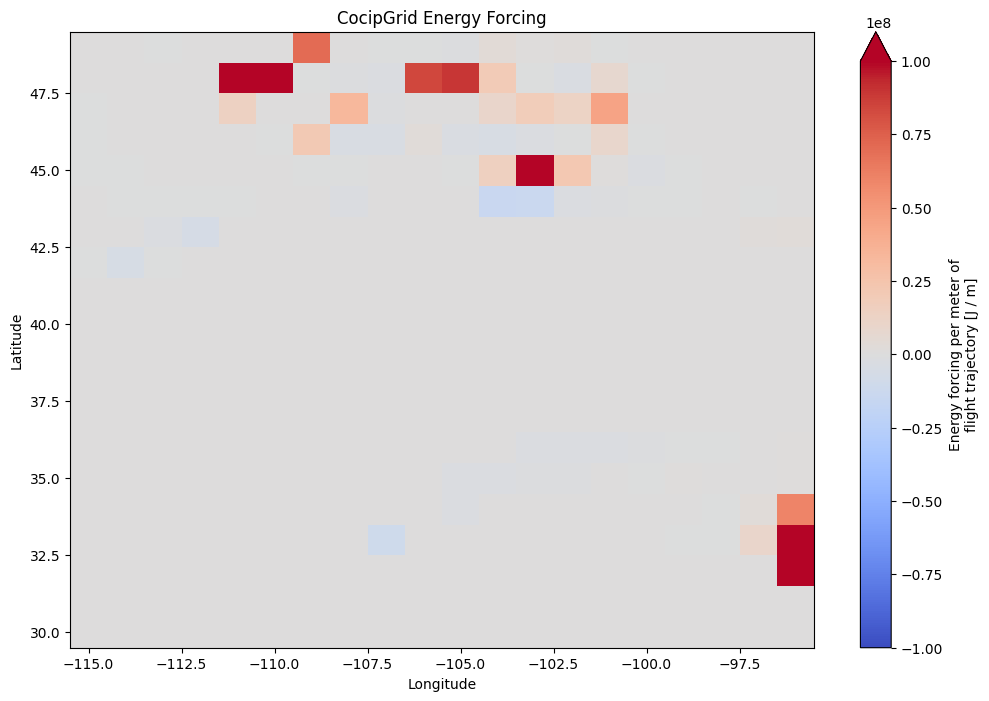

In [32]:
# Plot results
plt.figure(figsize=(12, 8))
ef_per_m = result.data["ef_per_m"].isel(time=0, level=0)
ef_per_m.plot(x="longitude", y="latitude", vmin=-1e8, vmax=1e8, cmap="coolwarm")

plt.title("CocipGrid Energy Forcing")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


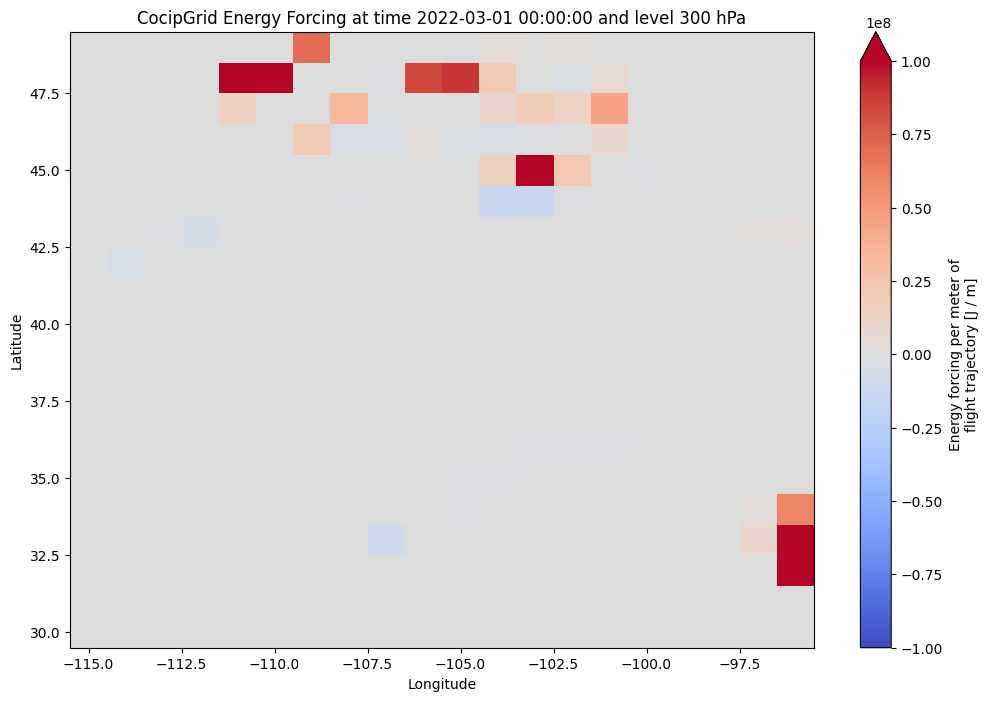

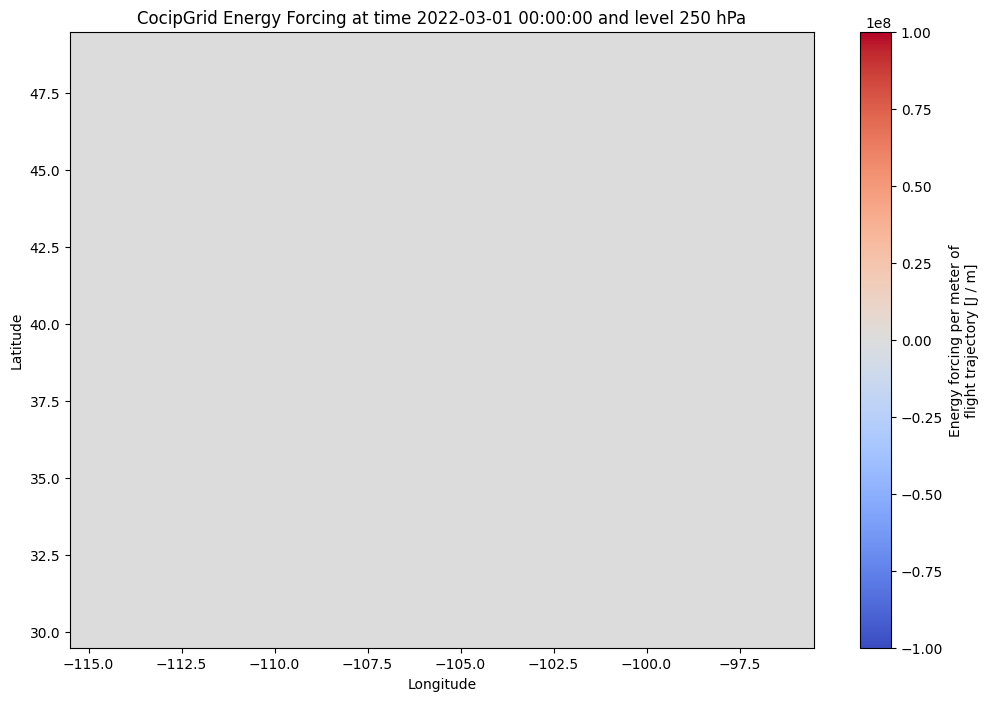

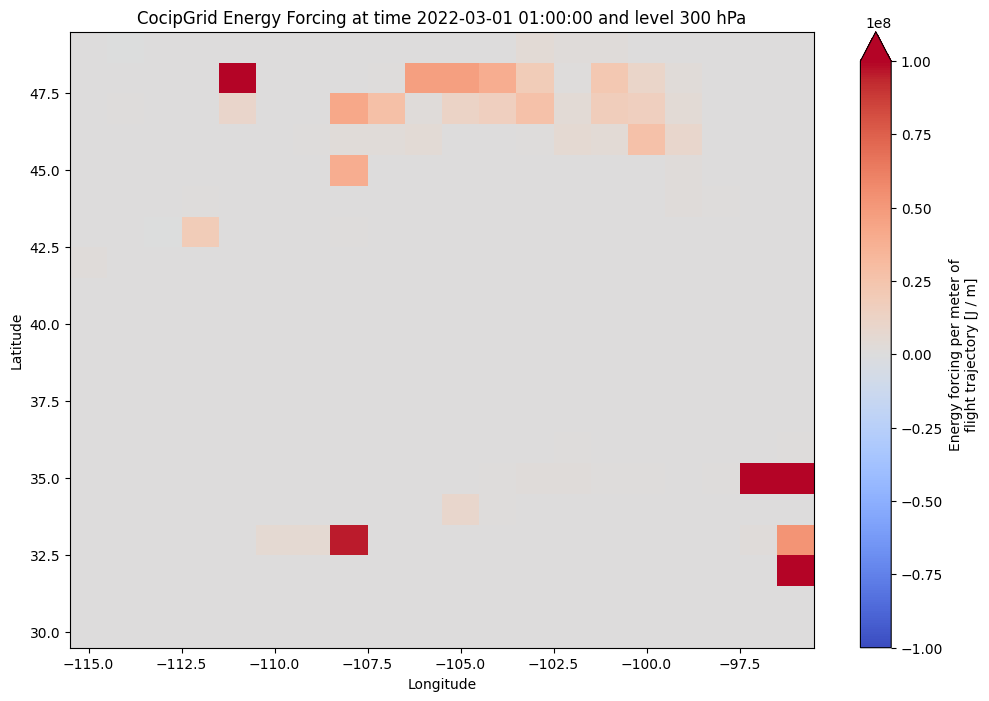

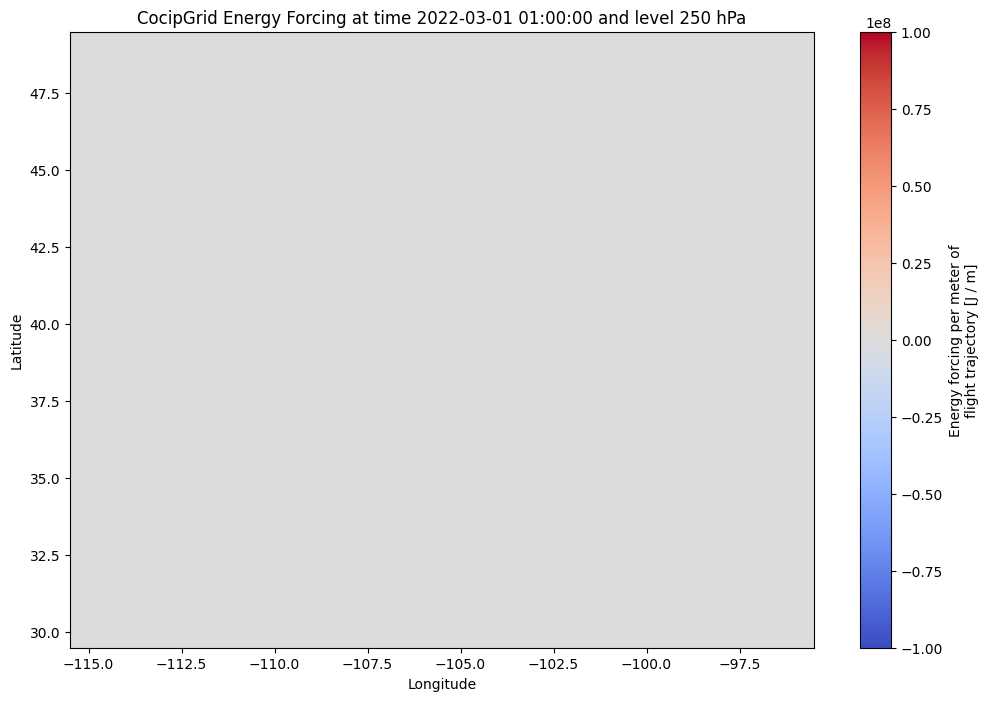

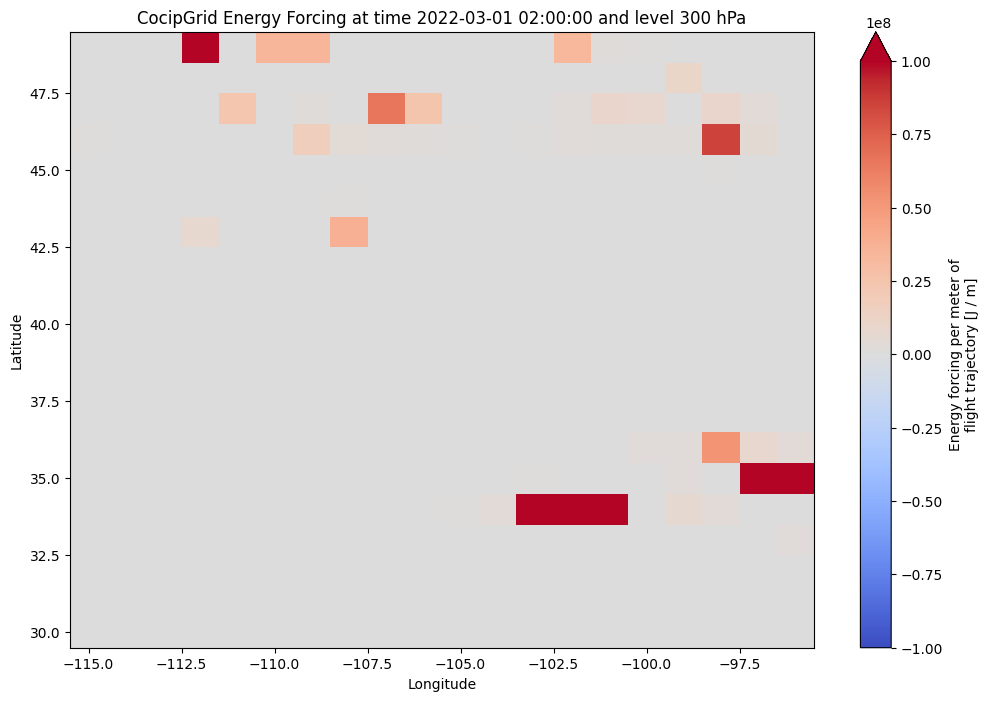

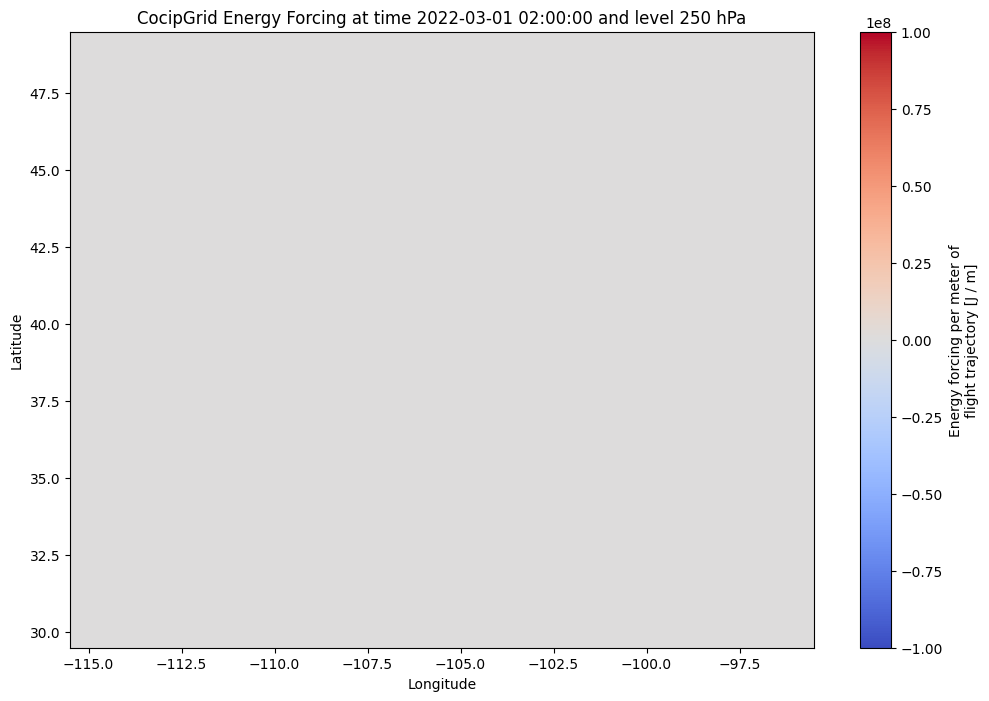

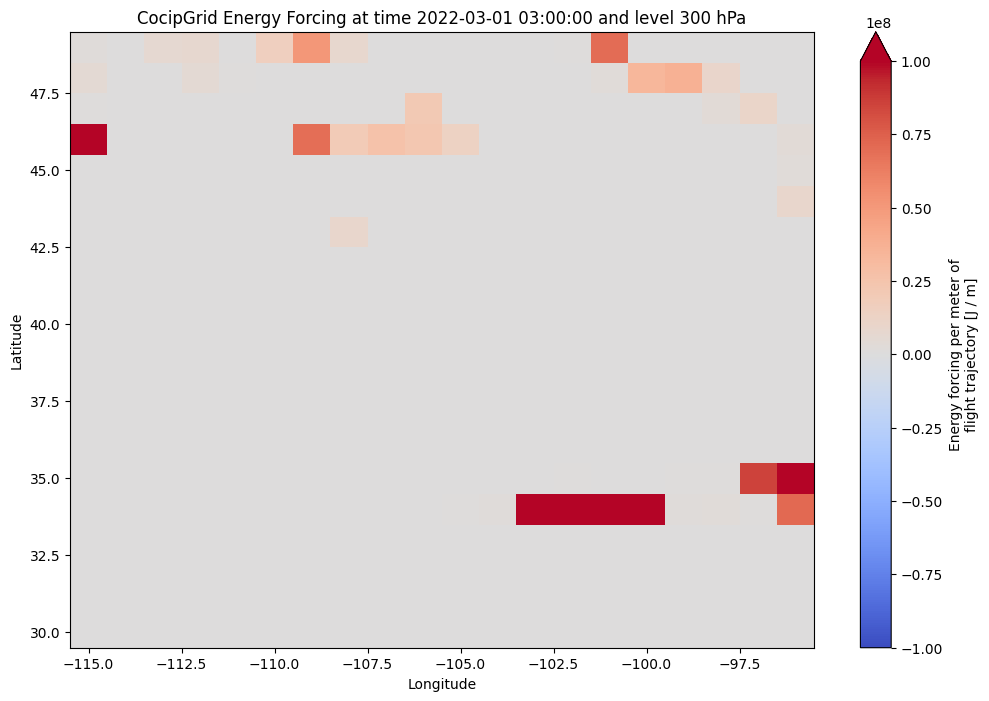

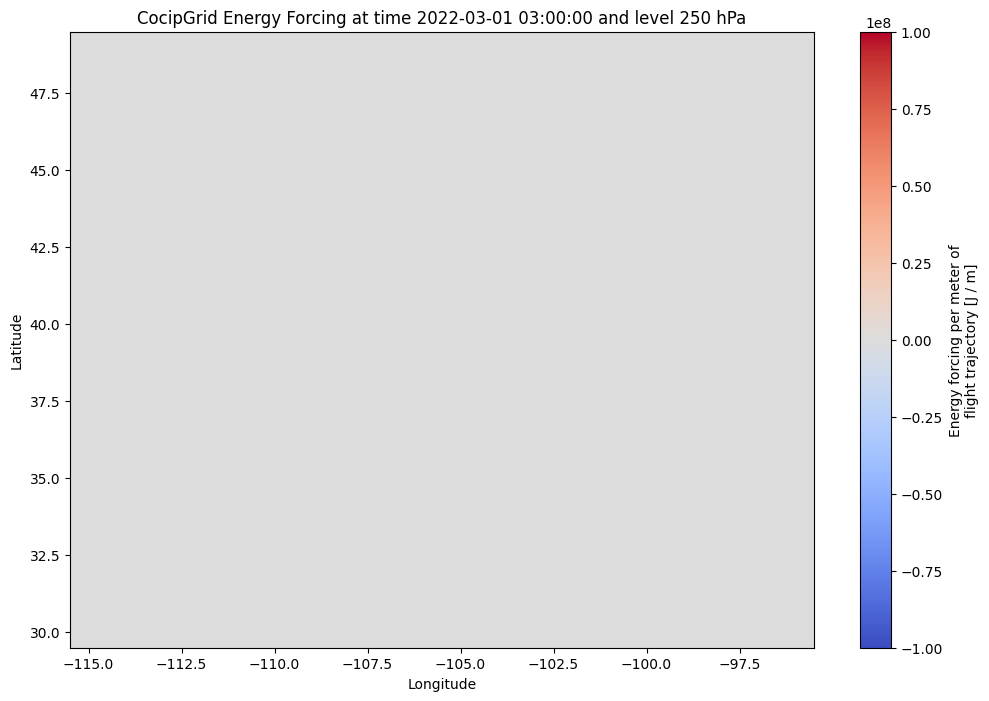

In [33]:
#generate plots that show the ef_per_m at each time step and pressure level
for t in range(len(coords["time"])):
    for p in range(len(coords["level"])):
        plt.figure(figsize=(12, 8))
        ef_per_m = result.data["ef_per_m"].isel(time=t, level=p)
        ef_per_m.plot(x="longitude", y="latitude", vmin=-1e8, vmax=1e8, cmap="coolwarm")
        plt.title(f"CocipGrid Energy Forcing at time {coords['time'][t]} and level {coords['level'][p]} hPa")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()



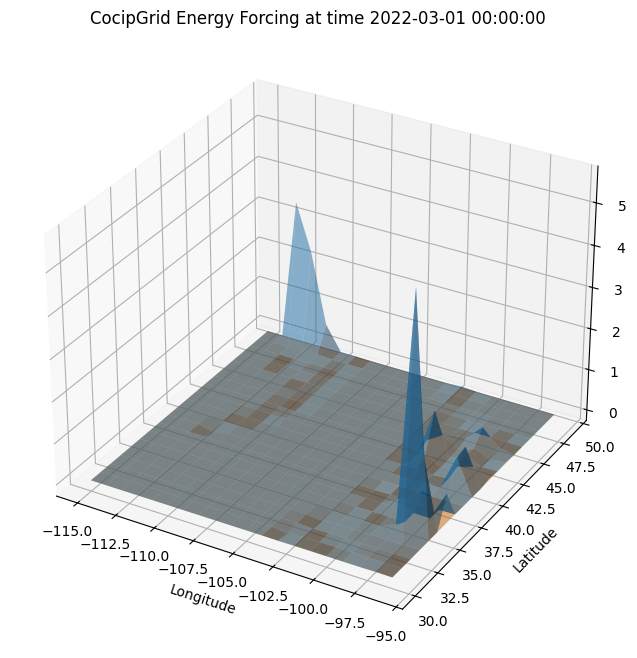

In [34]:
#create 3d plot for ef_per_m at each pressure level for one time step
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
time_index = 0  # first time step
X, Y = np.meshgrid(coords["longitude"], coords["latitude"])
for p in range(len(coords["level"])):
    Z = result.data["ef_per_m"].isel(time=time_index, level=p).values
    ax.plot_surface(X, Y, Z, label=f'Level {coords["level"][p]} hPa', alpha=0.5)
ax.set_title(f'CocipGrid Energy Forcing at time {coords["time"][time_index]}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Energy Forcing (ef_per_m)')
plt.show()

In [35]:
#show types in dataset
for var_name, var in result.data.variables.items():
    print(f"{var_name}: {var.dtype}")

#save dataset to netcdf
result.data.to_netcdf("cocipgrid_sample_result.nc")

longitude: float64
latitude: float64
level: float64
time: datetime64[ns]
air_pressure: float32
altitude: float32
contrail_age: float32
ef_per_m: float32
